In [16]:
import cv2 #opencv itself
import numpy as np # matrix manipulations
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
#the following are to do with this interactive notebook code
%matplotlib inline 
import os ,sys
import pandas as pd
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

# Reading the images dataset

In [17]:
IMAGE_DIRECTORY = '/Users/yacineflici/Documents/master-vmi/s2/projet-money/IMAGE_JPEG'
df = pd.read_excel('data annotations 3.xlsx')
df["Nom image"] = df["Nom image"].apply(lambda x: x.split(".")[0])
#reset index to image name 
df_indexed = df.set_index('Nom image')
#read all image in directory IMAGE
def load_images_names(folder):  
    images = []
    for filename in os.listdir(folder):
        #add the path to the file name
        images.append(os.path.join(folder,filename))
    return images
data = load_images_names(IMAGE_DIRECTORY)

# Binary Image

In [18]:
def binarize_image(image, threshold=None):    
    # # Convert the image to grayscale
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Check if a threshold is provided
    if threshold is not None:
        # Use the provided threshold
        _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    else:
        # Use Otsu's thresholding
        _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Return the binary image
    # binary_image = 255 - binary_image
    return binary_image

On a essayé au début de compter le nombre de pièces on utilisant la méthode de composante connexe and prendre les images qui ont une surface entre un min et un max

In [19]:
def label_and_count_connected_components(binary_image,min_surface_pixels=1000,max_surface_pixels=5000):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image,8, cv2.CV_32S)
    num_labels -= 1  # Adjusting for the background
    significant_component_count = 0
    
    output_image = np.zeros_like(binary_image)
    for i in range(num_labels):  # Start from 1 to ignore the background
        if stats[i, cv2.CC_STAT_AREA] >= min_surface_pixels  and stats[i, cv2.CC_STAT_AREA] <= max_surface_pixels:
            significant_component_count += 1
            output_image[labels == i] = 255
    # plt.imshow(output_image, cmap='gray')
            
    return significant_component_count, num_labels, stats, centroids

# Pour la classification des images on a essayé de faire une extraction des features en utilisant Harris Laplace et SIFT mais on a pas eu de bons résultats

In [20]:
def harris_laplace_descriptors(gray):
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    corners = cv2.dilate(corners, None)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian_of_gaussian = cv2.GaussianBlur(laplacian, (5, 5), 0)
    harris_laplace_response = corners * laplacian_of_gaussian
    threshold = 0.01 * harris_laplace_response.max()
    keypoints = []
    for y in range(harris_laplace_response.shape[0]):
        for x in range(harris_laplace_response.shape[1]):
            if harris_laplace_response[y, x] > threshold:
                keypoints.append(cv2.KeyPoint(x, y, size=10))
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.compute(gray, keypoints)
    return keypoints,descriptors



# Use Ransac

In [21]:
import cv2
import os
import numpy as np
import random

def create_coin_vocabulary_key_desc(image_dir, num_clusters=16, num_samples_per_coin=2):
    coin_vocabulary = {}
    # Step 1: Collect a dataset of images containing different Euro coins
    coin_directories = os.listdir(image_dir)

    for coin_dir in coin_directories:
        coin_path = os.path.join(image_dir, coin_dir)
        if not os.path.isdir(coin_path):
            continue
        
        # Randomly select images from each coin directory
        coin_images = os.listdir(coin_path)
        selected_images = random.sample(coin_images, max(num_samples_per_coin, len(coin_images)))
        coin_vocabulary[coin_dir] = []
        for image_file in selected_images:
            image_path = os.path.join(coin_path, image_file)

            # Step 2: Load and preprocess the coin images
            image = cv2.imread(image_path)
            #if size is empty
            if image is None:
                continue
            image = cv2.resize(image, (400, 400))
            # to gray
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Step 3: Apply feature extraction techniques (Harris-Laplace)
            keypoints,descriptors = harris_laplace_descriptors(image)
            # print(image_path)
            # print(coin_dir)
            # Step 4: Store descriptors in the vocabulary
            coin_vocabulary[coin_dir].append((keypoints,descriptors))
        print('Finished processing images for coin:', coin_dir, "nombres images: ",len(coin_vocabulary[coin_dir]))
    return coin_vocabulary

# Example usage:
train_dir = 'trainset_no_bg'
coin_vocabulary_desc_key = create_coin_vocabulary_key_desc(train_dir)


Finished processing images for coin: 10c nombres images:  6
Finished processing images for coin: 50c nombres images:  6
Finished processing images for coin: 20c nombres images:  6
Finished processing images for coin: 5c nombres images:  5
Finished processing images for coin: 2c nombres images:  6
Finished processing images for coin: 1e nombres images:  5
Finished processing images for coin: 1c nombres images:  5
Finished processing images for coin: 2e nombres images:  5


In [22]:
def test_single_coin_best_avg(test_image_gray, coin_vocabulary):
    # Extract descriptors from the test image
    keypoints, test_descriptors = harris_laplace_descriptors(test_image_gray)
    avg_distances_per_denomination = []
    # Iterate through each coin denomination in the vocabulary
    for denomination, coin_data in coin_vocabulary.items():
        avg_distances = []
        for coin_keypoints, coin_descriptors in coin_data:
            # FLANN parameters
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=50) # or pass empty dictionary
            flann = cv2.FlannBasedMatcher(index_params,search_params)
            # Match descriptors between test image and coin in the vocabulary
            matches = flann.knnMatch(test_descriptors, coin_descriptors, k=2)
            
            # Apply ratio test to get good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
            
            # Compute the distance of the matches
            distance = sum([match.distance for match in good_matches])
            avg_distances.append(distance)
            
        avg_distances_per_denomination.append((np.mean(avg_distances), denomination))
    avg_distances_per_denomination.sort(key=lambda x: x[0])
    return avg_distances_per_denomination, avg_distances_per_denomination[0][1]
def test_single_coin_best_match(test_image_gray, coin_vocabulary):
    # Extract descriptors from the test image
    keypoints, test_descriptors = harris_laplace_descriptors(test_image_gray)
    best_match_count = float('-inf')
    best_match_denomination = None
    # Iterate through each coin denomination in the vocabulary
    for denomination, coin_data in coin_vocabulary.items():
        for coin_keypoints, coin_descriptors in coin_data:
            # FLANN parameters
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=50) # or pass empty dictionary
            flann = cv2.FlannBasedMatcher(index_params,search_params)
            # Match descriptors between test image and coin in the vocabulary
            matches = flann.knnMatch(test_descriptors, coin_descriptors, k=2)
            
            # Apply ratio test to get good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
            if len(good_matches) <= 4:
                continue
            # estimate homography using RANSAC
            src_pts = np.float32([ keypoints[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
            dst_pts = np.float32([ coin_keypoints[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()
            # Compute the distance of the matches
            matches_count = sum(matchesMask)
            if matches_count > best_match_count:
                best_match_count = matches_count
                best_match_denomination = denomination
    return best_match_count, best_match_denomination


# Example usage:
test_image_path = 'trainset_no_bg/1e/train_2_3.png'
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (400, 400))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
avg_matches,best_match = test_single_coin_best_avg(test_image, coin_vocabulary_desc_key)
for i in avg_matches:
    print(f"Denomination : {i[1]} , Average distance : {i[0]}")
print(f"Best match by average: {best_match}")

best_match_distance,best_match = test_single_coin_best_match(test_image, coin_vocabulary_desc_key)
print(f"Best match by max : {best_match}")

Denomination : 20c , Average distance : 0.0
Denomination : 5c , Average distance : 0.0
Denomination : 2c , Average distance : 0.0
Denomination : 1c , Average distance : 0.0
Denomination : 50c , Average distance : 87.55303700764973
Denomination : 2e , Average distance : 199.54441833496094
Denomination : 1e , Average distance : 1097.6642486572266
Denomination : 10c , Average distance : 1699.2453689575195
Best match by average: 20c
Best match by max : 1e


# On a décidé de faire une extraction des features en utilisant les CNN et on utilise un model (Voir le fichier cnn_coin_classification.ipynb)

In [23]:
IMAGE_SIZE = (400,400)
def preprocess_single_image_cv2(image):
    resized_image = cv2.resize(image, IMAGE_SIZE)  # Resize the image to match the input shape of the model
    normalized_image = resized_image / 255.0  # Normalize pixel values to [0, 1]
    expanded_image = tf.expand_dims(normalized_image, 0)  # Add batch dimension
    return expanded_image
coin_classes = {'10c': 0, '50c': 1, '20c': 2, '5c': 3, '2c': 4, '1e': 5, '1c': 6, '2e': 7}
#coin_values from 10c to 2e example 10c = 0.1, 50c = 0.5, 20c = 0.2, 5c = 0.05, 2c = 0.02, 1e = 1, 1c = 0.01, 2e = 2
coin_values =  {"10c": 0.1, "50c": 0.5, "20c": 0.2, "5c": 0.05, "2c": 0.02, "1e": 1, "1c": 0.01, "2e": 2}
#load model coin_model.h5
model = tf.keras.models.load_model('/Users/yacineflici/Documents/master-vmi/s2/projet-money/coin_model (2).h5')

def predict_image(image_input):
    with open(os.devnull, 'w') as devnull:
    # Redirect stdout to devnull
        old_stdout = sys.stdout
        sys.stdout = devnull

        # Predict the class of the image
        predictions = model.predict(image_input)

    # Restore stdout
    sys.stdout = old_stdout
    return predictions

# Classe AnalyseImage
Entrée : image directory

Preprocessing :
- Lecture des images
- Conversion en HSV et enlever le flare
- Transformation en gris
- Filtre Gaussien
- Egalisation adaptative de l'histogramme
- Binarisation
- Filtre  morphologique (ouverture)
- Filtrage morphologique (fermeture)
- Erosion
- Detection des contours en utilisant Canny

Extraction des features :
- En utilisant fit ellipse on a essayé les contours qui sont dans la forme d'une ellipse avec une aire entre un min et un max
- Filtrage des ellipses qui ont une aire entre un min et un max, un angle entre un min et un max
- Filtrage ellipses qui ont une intersection sur union  plus de 50%
- Extraire les ROI des ellipses de l'image originale
- Extraire les features des ellipses en utilisant CNN
- Prédiction des classes des ellipses
- Compter la valeur des classes

/Users/yacineflici/Documents/master-vmi/s2/projet-money/IMAGE_JPEG/0e10c.jpg
Number of ellipses detected: 1
Predictions:
10c: 0.05%    50c: 0.11%    20c: 99.79%    5c: 0.00%    2c: 0.00%    1e: 0.00%    1c: 0.05%    2e: 0.00%    ['20c']
Final value of coins in image: 0.2


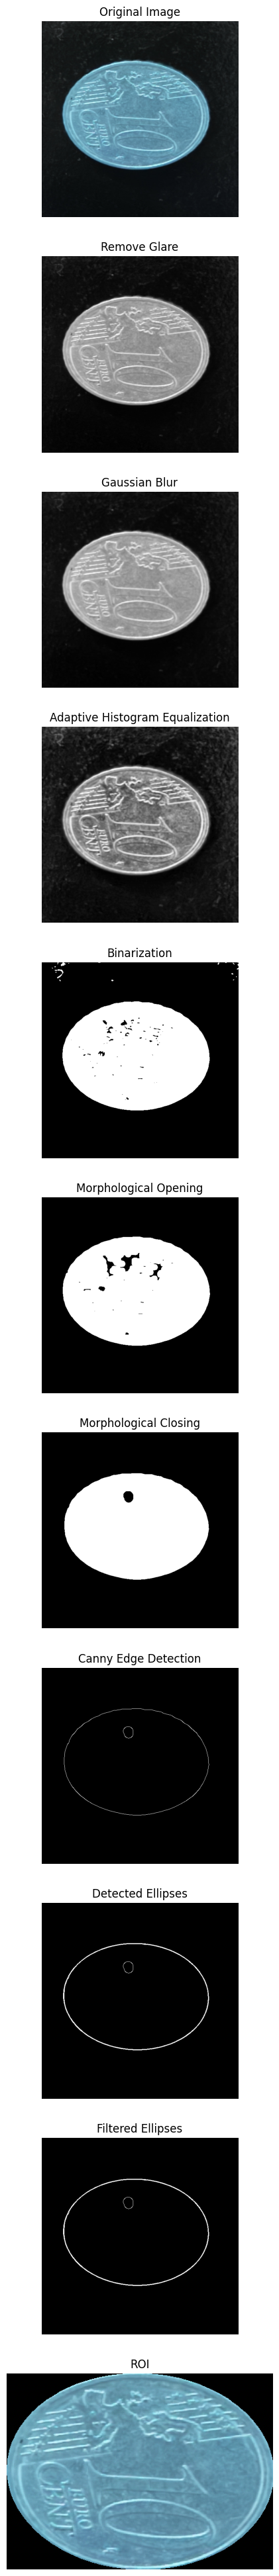

In [24]:

se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18, 18))
clahe_filter = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50))
morph_rect = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5, 5))
morph_ellipse = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5, 5))
morph_cross = cv2.getStructuringElement(shape=cv2.MORPH_CROSS, ksize=(5, 5))


class AnalyseImage():
    final_value = 0
    def __init__(self, path,log_steps=False):
        self.log_steps = log_steps
        self.steps = []
        self.path = path
        self.num_labels = 0
        self.image = cv2.imread(path)
        self.image = self.resize_image(self.image, 600, 600)
        self.copy = self.image.copy()        
        self.preprocess_image()
        self.output_image = self.copy
    def preprocess_image(self):
        if self.log_steps:
            self.steps.append((self.copy.copy(),"Original Image"))
        # # Convert to grayscale
        self.copy = self.remove_glare(self.copy)
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Remove Glare"))
        # # self.copy = cv2.cvtColor(self.copy, cv2.COLOR_BGR2GRAY)
        # # Gaussian blur
        self.copy = cv2.GaussianBlur(self.copy, (5, 5), 0)
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Gaussian Blur"))
        #equalize the histogram
        # self.copy = clahe_filter.apply(self.copy)        
        # if self.log_steps:
        #     self.steps.append( (self.copy.copy(),"Histogram Equalization"))
        
        # Apply adaptive histogram equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        self.copy = clahe.apply(self.copy)
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Adaptive Histogram Equalization"))
            
        # Binarize the image
        self.copy = binarize_image(self.copy.copy())
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Binarization"))
        # Morphological opening
        self.copy = cv2.morphologyEx(self.copy, cv2.MORPH_OPEN, se)
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Morphological Opening"))
        # # # Morphological closing
        self.copy = cv2.morphologyEx(self.copy, cv2.MORPH_CLOSE, se)

        #erode 
        self.copy = cv2.erode(self.copy, morph_cross, iterations=2)
        
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Morphological Closing"))
        # # # # #apply sobel filter
        self.copy = cv2.Canny(self.copy, 50, 100)
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Canny Edge Detection"))
        pass
    
    def filter_overlapping_ellipses(self):
        filtered_ellipses = []
        for i, ellipse1 in enumerate(self.detected):
            center, axes, angle = ellipse1
            #filter out ellipses with angle less than 30
            
            if angle <  80 :
                continue
            # #if axes are not at least only 50% bigger than the other ellipse
            if axes[0] > 3 * axes[1] or axes[1] > 3 * axes[0]:
                continue
            is_contained = False
            for j, ellipse2 in enumerate(self.detected):
                if i != j:
                    # Check if ellipse1 is entirely contained within ellipse2
                    if self.is_ellipse_contained(ellipse1, ellipse2):
                        is_contained = True
                        break
            if not is_contained:
                filtered_ellipses.append(ellipse1)
        #remove drawn ellipses from image
        if self.log_steps:
            for ellipse in self.detected:
                cv2.ellipse(self.copy, ellipse, (0, 0, 0), 2)
        self.detected = filtered_ellipses
        if self.log_steps:
            for ellipse in self.detected:
                cv2.ellipse(self.copy, ellipse, (255, 255, 255), 2)
            self.steps.append( (self.copy.copy(),"Filtered Ellipses"))

    def is_ellipse_contained(self, ellipse1, ellipse2, iou_threshold=50):
        # Get the parameters of ellipse1
        center1, axes1, angle1 = ellipse1
        # Get the parameters of ellipse2
        center2, axes2, angle2 = ellipse2
        
        # Convert ellipse parameters to integers
        center1 = (int(center1[0]), int(center1[1]))
        center2 = (int(center2[0]), int(center2[1]))
        axes1 = (int(axes1[0] / 2), int(axes1[1] / 2))
        axes2 = (int(axes2[0] / 2), int(axes2[1] / 2))
        
        # Convert ellipse parameters to angles in degrees
        angle1 = int(angle1)
        angle2 = int(angle2)
        
        # Define start and end angles for ellipse1 and ellipse2
        start_angle1 = 0
        end_angle1 = 360
        start_angle2 = 0
        end_angle2 = 360
        
        # Get the bounding rectangles of the ellipses
        rect1 = cv2.boundingRect(cv2.ellipse2Poly(center1, axes1, angle1, start_angle1, end_angle1, delta=1))
        rect2 = cv2.boundingRect(cv2.ellipse2Poly(center2, axes2, angle2, start_angle2, end_angle2, delta=1))
            
        # Calculate intersection area
        intersection_area = max(0, min(rect1[0] + rect1[2], rect2[0] + rect2[2]) - max(rect1[0], rect2[0])) * \
                            max(0, min(rect1[1] + rect1[3], rect2[1] + rect2[3]) - max(rect1[1], rect2[1]))
        
        # Calculate union area
        union_area = rect1[2] * rect1[3] + rect2[2] * rect2[3] - intersection_area
        
        # Calculate IoU
        iou = intersection_area / union_area
        
        # Check if IoU is greater than the threshold
        return iou > iou_threshold


    def detect_harris_laplace_keypoints(self):
        # gray = cv2.cvtColor(self.copy, cv2.COLOR_BGR2GRAY)
        harris_laplace = cv2.xfeatures2d.HarrisLaplaceFeatureDetector_create()
        keypoints = harris_laplace.detect(self.copy)
        if self.log_steps:
            image_with_keypoints = cv2.drawKeypoints(self.copy, keypoints, None)
            self.steps.append( (image_with_keypoints.copy(),"Detected Keypoints"))
        num_keypoints = len(keypoints)
        self.num_labels = num_keypoints
        return image_with_keypoints

    def detect_ellipses(self):
        # Find contours
        contours, _ = cv2.findContours(self.copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.detected =  []
    
        for contour in contours:
            # Fit ellipse to each contour
            if len(contour) >= 5:
                ellipse = cv2.fitEllipse(contour)
                #check area of contour
                if cv2.contourArea(contour) < 25:
                    continue
                self.detected.append(ellipse)
                if self.log_steps:         
                    # Draw the ellipse on the image (optional)
                    cv2.ellipse(self.copy, ellipse, (255, 255, 255), 2)
       
        self.num_labels = len(self.detected)
        if self.log_steps:
            print(f'Number of ellipses detected: {self.num_labels}')
            self.steps.append( (self.copy.copy(),"Detected Ellipses"))
    
    
    def extract_roi_from_ellipses(self):
        # Extract ROI corresponding to detected ellipses
        self.rois = []
        for ellipse in self.detected:
            #get bounding box of ellipse
            contour_points = cv2.ellipse2Poly(
                        (int(ellipse[0][0]), int(ellipse[0][1])),
                        (int(ellipse[1][0] / 2), int(ellipse[1][1] / 2)),
                        int(ellipse[2]),
                        0, 360, 10)
                    
                    # Get bounding rectangle of the contour
            x, y, w, h = cv2.boundingRect(contour_points)
            
            mask = np.zeros_like(self.image)
            cv2.ellipse(mask, ellipse, (255, 255, 255), -1)
            # Extract pixels inside the ellipse
            ellipse_pixels = cv2.bitwise_and(self.image, mask)
            roi = ellipse_pixels[y:y+h, x:x+w] 
            if roi.size == 0:
                continue
            self.rois.append(roi) 

        if self.log_steps:
            for roi in self.rois:
                self.steps.append( (roi.copy(),"ROI"))
        # return self.rois

    
    def get_preprocessed_rgb_image(self):
        return cv2.cvtColor(self.copy, cv2.COLOR_GRAY2RGB)
    def count_connected_components(self, image, min_surface_pixels=10, max_surface_pixels=1000000):
        self.num_labels, self.labels, self.stats, self.centroids = label_and_count_connected_components(
            image, min_surface_pixels, max_surface_pixels)
        #find max surface
        max_surfaces = []
        for i in range(1, self.num_labels):
            max_surfaces.append(self.stats[i, cv2.CC_STAT_AREA])
        
        #remove outliers max and min
        max_surfaces.remove(max(max_surfaces))
        max_surfaces.remove(min(max_surfaces))
        
        #avg the max surface
        self.chosen_surface = int(np.mean(max_surfaces))
        self.chosen_surface *= 0.5
        self.chosen_surface = int(self.chosen_surface)
        print(f'Number of connected components: {self.num_labels} , max surface: {self.chosen_surface}')

    def detect_coins(self):
        circles = cv2.HoughCircles(self.copy, cv2.HOUGH_GRADIENT, dp=1, minDist=30, param1=200, param2=30, minRadius=10, maxRadius=100)
        coin_number = 0
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0, :]:
                center = (circle[0], circle[1])
                radius = circle[2]
                if 0 <= radius <= 10000:
                    coin_number += 1
                    if  self.log_steps:
                        cv2.circle(self.copy, center, radius, (255, 255, 255), 2)
        if self.log_steps:
            self.steps.append( (self.copy.copy(),"Detected Coins"))
        self.num_labels = coin_number
        print(f'Number of coins detected: {coin_number}')

    def remove_glare(self, img):
        # Convert to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Define glare threshold
        GLARE_MIN = np.array([0, 0, 50], np.uint8)
        GLARE_MAX = np.array([0, 0, 225], np.uint8)

        # Create mask for glare
        mask = cv2.inRange(hsv_img, GLARE_MIN, GLARE_MAX)
        # Inpainting to remove glare
        result = cv2.inpaint(img, mask, 0.1, cv2.INPAINT_TELEA)
        # Convert to grayscale
        result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        return result
    def resize_image(self,image,width,height):
        image = cv2.resize(image, (width, height))
        return image
    def plot_steps(self):
        # plot in same row
        fig, axs = plt.subplots(1, len(self.steps), figsize=(50, 50))
        for i, step in enumerate(self.steps):
            img, title = step
            axs[i].imshow(img, cmap='gray')
            axs[i].set_title(title)
            axs[i].axis('off')
    def plot_vertical(self):
        fig, axs = plt.subplots(len(self.steps), 1, figsize=(50, 50))
        for i, step in enumerate(self.steps):
            img, title = step
            if img.ndim == 2:
                axs[i].imshow(img, cmap='gray')
            else:
                axs[i].imshow(img)
            axs[i].set_title(title)
            axs[i].axis('off')
        
    def draw_roi(self):
        # plot in same row
        fig, axs = plt.subplots(1, len(self.rois)+1, figsize=(20, 20))
        for i, step in enumerate(self.rois):
            axs[i].imshow(step, cmap='gray')
            axs[i].set_title(f'Step {i + 1}')
            axs[i].axis('off') 
    
    def find_best_match_cnn(self,roi):
        #find best match for roi
        model_input = preprocess_single_image_cv2(roi)
        predictions = predict_image(model_input)
        if self.log_steps:
            print('Predictions:')
            for i, prediction in enumerate(predictions[0]):
                print(f'{list(coin_classes.keys())[i]}: {prediction*100:.2f}%',end='    ')

        #if max prediction is less than 0.5 return None
        if np.max(predictions) < 0.5:
            return None
        # Get the predicted class label
        predicted_class_index = tf.argmax(predictions, axis=1)[0]
        
        predicted_class = list(coin_classes.keys())[list(coin_classes.values()).index(predicted_class_index)]
        return predicted_class

    
    def find_best_match(self,roi):
        #find best match for roi
        roi = cv2.resize(roi, (400, 400))
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        matches_avgs,best_match  = test_single_coin_best_match(roi, coin_vocabulary_desc_key)
        if self.log_steps:
            print(matches_avgs)
            print(f"Best match : {best_match}")
        return best_match

    def coins_in_image(self,is_cnn=True):
        self.coins = []
        for roi in self.rois:
            if is_cnn:
                self.coins.append(self.find_best_match_cnn(roi))
            else:
                self.coins.append(self.find_best_match(roi))
        for coin in self.coins:
            if coin is not None:
                self.final_value += coin_values[coin]
        if self.log_steps:
            print(self.coins)
            print(f'Final value of coins in image: {self.final_value}')
img_path = data[1]
print(os.path.join(os.getcwd(),img_path))
image_obj = AnalyseImage(img_path,log_steps=True)
image_obj.detect_ellipses()
image_obj.filter_overlapping_ellipses()
image_obj.extract_roi_from_ellipses()
# print(f"Number of labels detected: {image_obj.num_labels}")
#test each roi for best denomination
image_obj.coins_in_image()
# print(f"Final value of coins in image: {image_obj.final_value}")
image_obj.plot_vertical()

# Prédiction sur les images de test CNN

In [50]:
from tqdm import tqdm
#loop around the image
#set index to Nom image
df_indexed["Nombre de pièces détectées"] = None 
df_indexed["Bien détecté"] = None
df_indexed["Valeur détectée"] = None
#make it int 
df_indexed["Nombre de pièces"] =  df_indexed["Nombre de pièces"].astype(int)

for i in tqdm(range(len(data))):
    image_path = data[i]
    image = AnalyseImage(image_path)
    image.detect_ellipses()
    image.filter_overlapping_ellipses()
    image.extract_roi_from_ellipses()
    image.coins_in_image()
    image_name = image_path.split('/')[-1].split('.')[0]
    df_indexed.loc[image_name,"Nombre de pièces détectées"] = image.num_labels
    if  image.num_labels  == df_indexed.loc[image_name]["Nombre de pièces"]:
        df_indexed.loc[image_name,"Bien détecté"] = True 
    else:
        df_indexed.loc[image_name,"Bien détecté"] = False
    df_indexed.loc[image_name,"Valeur détectée"] = image.final_value
    # print(f"Image {image_path} has {image.num_labels} == {df.loc[image_name]['Nombre de pièces']} {data.index(image_path)}/{len(data)}")

100%|██████████| 92/92 [00:18<00:00,  4.86it/s]


In [51]:
print(df_indexed["Bien détecté"].value_counts())
df_indexed["Différence"] = df_indexed["Nombre de pièces"] - df_indexed["Nombre de pièces détectées"]
df_indexed["Différence Valeur"] = df_indexed["Valeur "] - df_indexed["Valeur détectée"]
#save to excel
df_indexed.to_excel('results.xlsx',index=True)

Bien détecté
False    64
True     28
Name: count, dtype: int64


# Accuracy for number of coins using CNN

In [52]:
#mesure de performance
#accuracy
accuracy = df_indexed["Bien détecté"].value_counts()[True] / len(df_indexed)
print(f"Accuracy: {accuracy}")

Accuracy: 0.30434782608695654


# Mean Absolute Error for the sum value of coins using CNN

In [53]:
#mean absolute error for value
mae = np.abs(df_indexed["Valeur détectée"] - df_indexed["Valeur "]).mean()
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1.842608695652175


# Prédiction sur les images de test Features matching

/Users/yacineflici/Documents/master-vmi/s2/projet-money/IMAGE_JPEG/IMG_1645.JPG
Number of ellipses detected: 6
0
Best match : 5c
0
Best match : 2e
-inf
Best match : None
-inf
Best match : None
-inf
Best match : None
-inf
Best match : None
['5c', '2e', None, None, None, None]
Final value of coins in image: 2.05


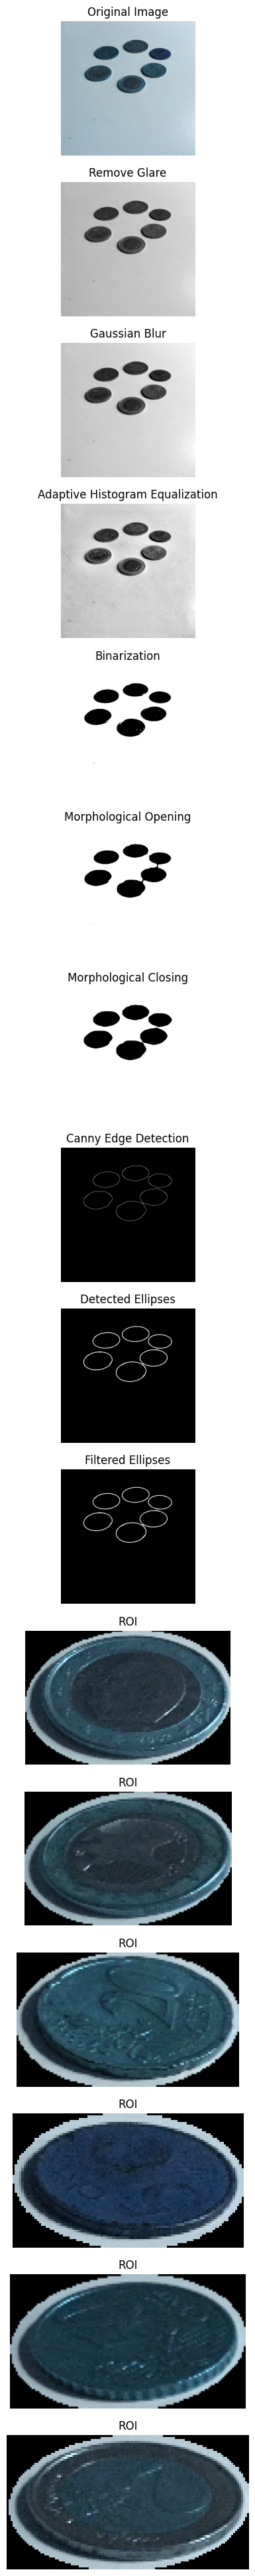

In [15]:
#test using histogram distance

img_path = data[7]
print(os.path.join(os.getcwd(),img_path))
image_obj = AnalyseImage(img_path,log_steps=True)
image_obj.detect_ellipses()
image_obj.filter_overlapping_ellipses()
image_obj.extract_roi_from_ellipses()
# print(f"Number of labels detected: {image_obj.num_labels}")
#test each roi for best denomination
image_obj.coins_in_image(False)
# print(f"Final value of coins in image: {image_obj.final_value}")
image_obj.plot_vertical()

In [46]:
from tqdm import tqdm
df_hist = df_indexed.copy()
df_hist["Nombre de pièces détectées"] = None
df_hist["Bien détecté"] = None
df_hist["Valeur détectée"] = None
df_hist["Différence"] = None
df_hist["Différence Valeur"] = None
df_hist["Histogram Distance"] = None
df_hist["Valeur détectée"] = None
df_hist["Nombre de pièces"] =  df_hist["Nombre de pièces"].astype(int)

for i in tqdm(range(len(data))):
    image_path = data[i]
    image = AnalyseImage(image_path)
    image.detect_ellipses()
    image.filter_overlapping_ellipses()
    image.extract_roi_from_ellipses()
    image.coins_in_image(False)
    image_name = image_path.split('/')[-1].split('.')[0]
    df_hist.loc[image_name,"Nombre de pièces détectées"] = image.num_labels
    if  image.num_labels  == df_hist.loc[image_name]["Nombre de pièces"]:
        df_hist.loc[image_name,"Bien détecté"] = True 
    else:
        df_hist.loc[image_name,"Bien détecté"] = False
    df_hist.loc[image_name,"Valeur détectée"] = image.final_value
    df_hist.loc[image_name,"Histogram Distance"] = compare_histograms(histogram1, histogram2)
    df_hist.loc[image_name,"Différence"] = df_hist.loc[image_name]["Nombre de pièces"] - df_hist.loc[image_name]["Nombre de pièces détectées"]
    df_hist.loc[image_name,"Différence Valeur"] = df_hist.loc[image_name]["Valeur "] - df_hist.loc[image_name]["Valeur détectée"]
    # print(f"Image {image_path} has {image.num_labels} == {df.loc[image_name]['Nombre de pièces']} {data.index(image_path)}/{len(data)}")

100%|██████████| 92/92 [09:08<00:00,  5.97s/it]


In [47]:
print(df_hist["Bien détecté"].value_counts())
df_hist["Différence"] = df_hist["Nombre de pièces"] - df_hist["Nombre de pièces détectées"]
df_hist["Différence Valeur"] = df_hist["Valeur "] - df_hist["Valeur détectée"]
#save to excel
df_hist.to_excel('results flann match.xlsx',index=True)

Bien détecté
False    64
True     28
Name: count, dtype: int64


# Accuracy for number of coins using features matching

In [48]:
#mesure de performance
#accuracy
accuracy = df_hist["Bien détecté"].value_counts()[True] / len(df_hist)
print(f"Accuracy: {accuracy}")

Accuracy: 0.30434782608695654


# Mean Absolute Error for the sum value of coins using features matching

In [49]:
#mean absolute error for value
mae = np.abs(df_hist["Valeur détectée"] - df_hist["Valeur "]).mean()
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1.7815217391304339
